# IQNx4: 2. Tune Hyperparameters of all IQNs


There is a live executable version of this notebook on binder, just click this link : [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AliAlkadhim/torchQN/HEAD?labpath=JupyterBook)

Note that the binder will take a while to build, and you'd have to navigate through the files yourself (not as easy or nice as just going to https://alialkadhim.github.io/torchQN/)



In [1]:
import numpy as np; import pandas as pd
# import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn; print(f"using torch version {torch.__version__}")
#use numba's just-in-time compiler to speed things up
# from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; print('matplotlib version= ', mp.__version__)

import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
#reset matplotlib parameters to their defaults
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import sys; import os
from IPython.display import Image, display
# from importlib import import_module
import plotly
try:
    import optuna
    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
import time
# import sympy as sy
import ipywidgets as wid; 

using torch version 1.9.0
matplotlib version=  3.5.1
using (optional) optuna version 2.8.0


In [25]:
# env = {}
# env.update(os.environ)
# env.update(source(os.environ["IQN_BASE"])) 
try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils/')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('DATA directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    # IQN_BASE=os.getcwd()
    print("""\nBASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do 
    os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>
    or
    os.environ['IQN_BASE']=os.getcwd()""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


In [26]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this:
wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

In [27]:
################################### CONFIGURATIONS ###################################
DATA_DIR=os.environ['DATA_DIR']
JUPYTER=True
use_subsample=False
if use_subsample:
    SUBSAMPLE=int(1e5)#subsample use for development - in production use whole dataset
else:
    SUBSAMPLE=None

In [28]:
################################### SET DATA CONFIGURATIONS ###################################
X       = ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

#set order of training:
#pT_first: pT->>m->eta->phi
#m_first: m->pT->eta->phi




ORDER='m_First'

if ORDER=='m_First':
    FIELDS  = {'RecoDatam' : {'inputs': X, 
                               'xlabel':  r'$m$ (GeV)', 
                              'ylabel':'$m^{reco}$',
                               'xmin': 0, 
                               'xmax': 25},
                           

               'RecoDatapT': {'inputs': ['RecoDatam']+X, 
                               'xlabel':  r'$p_T$ (GeV)' , 
                              'ylabel': '$p_T^{reco}$',
                               'xmin'  : 20, 
                               'xmax'  :  80},

               'RecoDataeta': {'inputs': ['RecoDatam','RecoDatapT'] + X, 
                               'xlabel': r'$\eta$',
                               'ylabel':'$\eta^{reco}$',
                               'xmin'  : -5,
                               'xmax'  :  5},

               'RecoDataphi'  : {'inputs': ['RecoDatam', 'RecodatapT', 'RecoDataeta']+X,
                               'xlabel': r'$\phi$' ,
                                'ylabel' :'$\phi^{reco}$',
                               'xmin'  : -3.2, 
                               'xmax'  :3.2}
              }

In [29]:
all_variable_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']
all_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'tau']
################################### Load unscaled dataframes ###################################
print(f'SUBSAMPLE = {SUBSAMPLE}')
raw_train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                      usecols=all_cols,
                      nrows=SUBSAMPLE
                      )

raw_test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                      usecols=all_cols,
                     nrows=SUBSAMPLE
                     )

raw_valid_data=pd.read_csv(os.path.join(DATA_DIR,'validation_data_10M_2.csv'),
                      usecols=all_cols,
                      nrows=SUBSAMPLE
                      )

SUBSAMPLE = None


['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam']
['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']
Reco_var:  RecoDatapT , 	 gen_var:  genDatapT
Reco_var:  RecoDataeta , 	 gen_var:  genDataeta
Reco_var:  RecoDataphi , 	 gen_var:  genDataphi
Reco_var:  RecoDatam , 	 gen_var:  genDatam


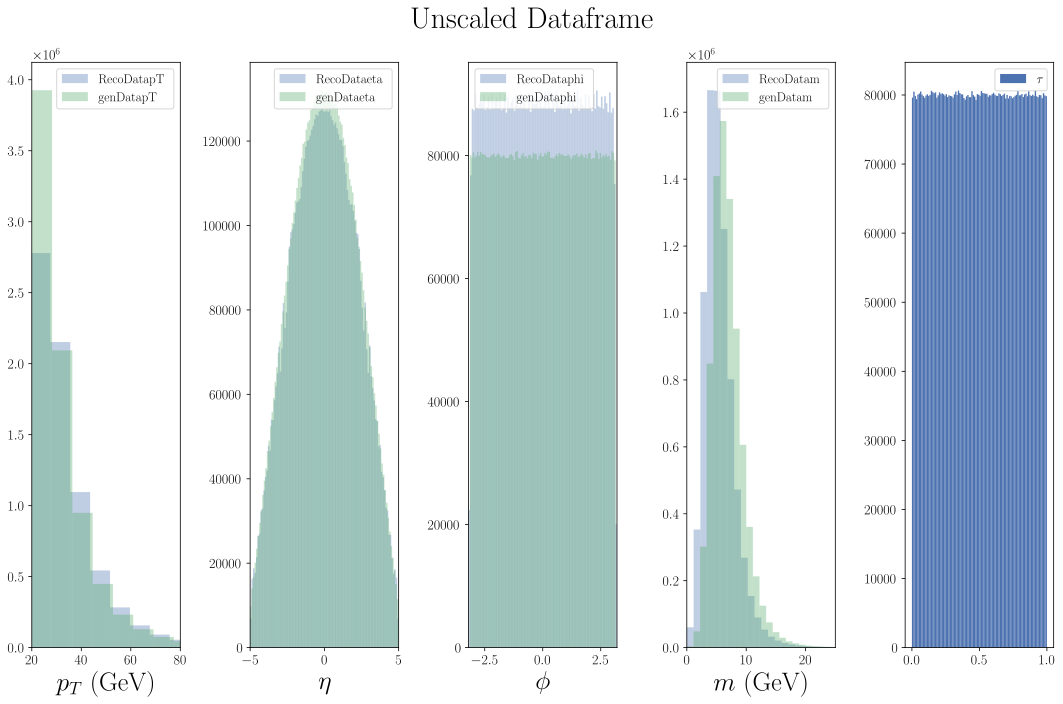

In [30]:
explore_data(df=raw_train_data, title='Unscaled Dataframe')

## If you want to generate the Scaled data frames, run the cell below

          genDatapT    RecoDatapT    genDataeta   RecoDataeta    genDataphi  \
count  8.000000e+06  8.000000e+06  8.000000e+06  8.000000e+06  8.000000e+06   
mean   3.421245e+00  3.412002e+00 -1.781882e-03 -1.789886e-03 -3.830903e-04   
std    3.348063e-01  3.804798e-01  2.204310e+00  2.197969e+00  1.813825e+00   
min    2.995732e+00  2.437457e+00 -5.227320e+00 -5.006930e+00 -3.141590e+00   
25%    3.168285e+00  3.156336e+00 -1.654600e+00 -1.651130e+00 -1.571320e+00   
50%    3.346474e+00  3.366927e+00 -2.726765e-03 -3.001240e-03  6.159285e-05   
75%    3.591181e+00  3.624294e+00  1.651250e+00  1.647990e+00  1.570300e+00   
max    6.733142e+00  6.703041e+00  5.188200e+00  5.005230e+00  3.141590e+00   

        RecoDataphi      genDatam     RecoDatam           tau  
count  8.000000e+06  8.000000e+06  8.000000e+06  8.000000e+06  
mean  -4.719170e-04  2.150564e+00  1.967802e+00  4.999153e-01  
std    1.814474e+00  2.880059e-01  3.271235e-01  2.886730e-01  
min   -3.480195e+00  6.927950e-0

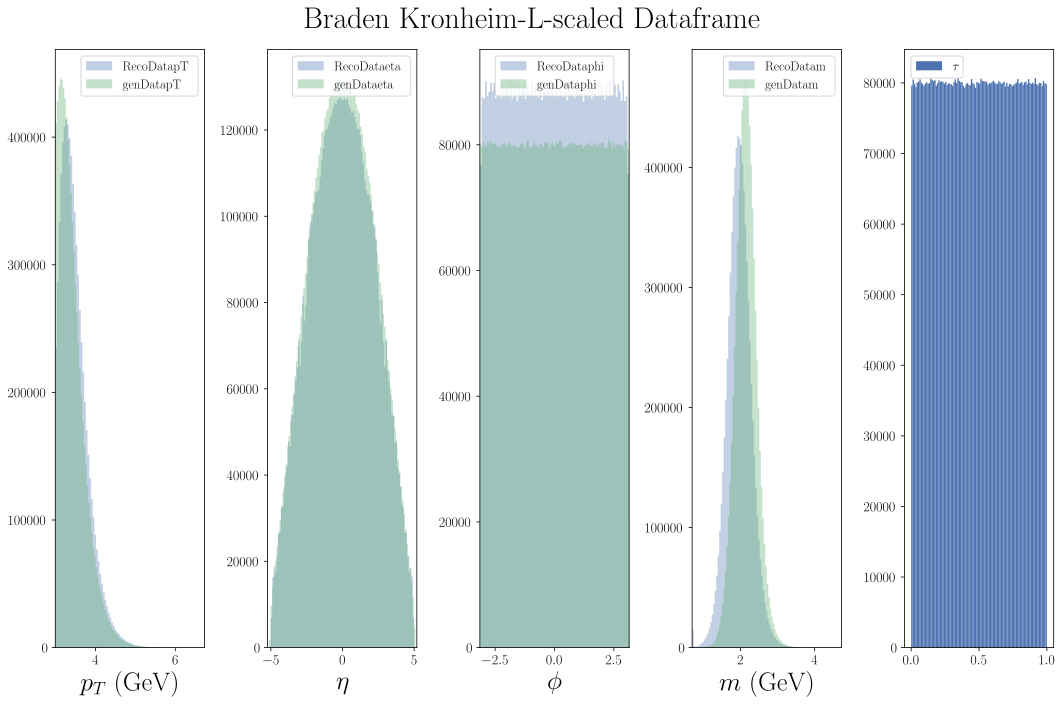

In [35]:
# scaled_train_data = L_scale_df(raw_train_data, title='scaled_train_data_10M_2.csv',
#                              save=True)
# print('\n\n')
# scaled_test_data = L_scale_df(raw_test_data,  title='scaled_test_data_10M_2.csv',
#                             save=True)
# print('\n\n')

# scaled_valid_data = L_scale_df(raw_valid_data,  title='scaled_valid_data_10M_2.csv',
#                             save=True)

# explore_data(df=scaled_train_data, title='Braden Kronheim-L-scaled Dataframe', scaled=True)

## If you want to load the previously generated scaled dataframe, run the cell below

USING NEW DATASET

TRAINING FEATURES
    genDatapT  RecoDatapT  genDataeta  RecoDataeta  genDataphi  RecoDataphi  \
0   3.382531    3.463020    0.828187     0.817082    2.902130     2.919510   
1   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
2   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
3   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
4   3.004211    3.187005    1.844410     1.837910   -0.186685    -0.160621   

   genDatam  RecoDatam       tau  
0  1.579696   1.525158  0.361310  
1  2.058837   1.995432  0.126899  
2  2.058837   1.995432  0.962307  
3  2.058837   1.995432  0.457282  
4  2.040038   1.886115  0.840862  

TESTING FEATURES
    genDatapT  RecoDatapT  genDataeta  RecoDataeta  genDataphi  RecoDataphi  \
0   3.775316    3.791603    0.824891     0.824645    -1.26949     -1.26117   
1   3.775316    3.791603    0.824891     0.824645    -1.26949     -1.26117   
2   3.258685    3.313277    3.

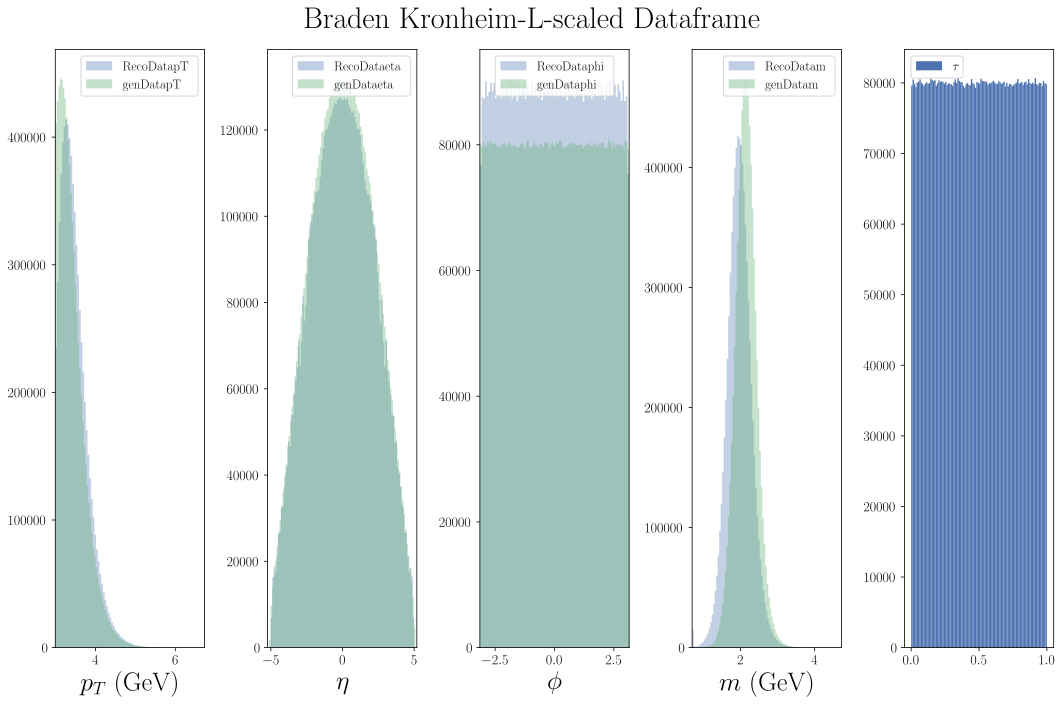

In [36]:


print('USING NEW DATASET\n')
#UNSCALED
# train_data_m=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)

# print('TRAINING FEATURES\n', train_data.head())

# test_data_m= pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)
# print('\nTESTING FEATURES\n', test_data.head())
# valid_data= pd.read_csv(os.path.join(DATA_DIR,'valid_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)


# SCALED
train_data_m=pd.read_csv(os.path.join(DATA_DIR,'scaled_train_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)

print('TRAINING FEATURES\n', train_data_m.head())

test_data_m= pd.read_csv(os.path.join(DATA_DIR,'scaled_test_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)

valid_data_m= pd.read_csv(os.path.join(DATA_DIR,'scaled_valid_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)
print('\nTESTING FEATURES\n', test_data_m.head())

print('\ntrain set shape:',  train_data_m.shape)
print('\ntest set shape:  ', test_data_m.shape)
# print('validation set shape:', valid_data.shape)

scaled_train_data = train_data_m
scaled_test_data = test_data_m
scaled_valid_data = valid_data_m

explore_data(df=scaled_train_data, title='Braden Kronheim-L-scaled Dataframe', scaled=True)

closerclosercloserclosercloser---------
------
# ML

Note that this ideas is very powerful and has the potential to replace the use of Delphes/GEANT for most people. According to the [previous paper](https://arxiv.org/pdf/2111.11415.pdf) this method already works for a single IQN, and we know it works reasonably well for autoregressive IQNx4, [as we said above](#Results_prior) .

It's important to remember "the master formula" of all of machine learning:

$$\int \frac{\partial L}{\partial f} p(y|x) dy  = 0 \tag{1}$$

or, equivalently, 

$$ \frac{\delta R}{\delta f}=0,$$

where $L$ is the loss function, $f$ is the model (neural network/classifier/regressor, etc. In this case it's an IQN) (implicitly parameterized by potentially a  gazillion parameters), 

and $p(y|x)$ the PDF of targets $y$ that we want to estimate, given (set of) features $x$, $R$ is the risk functional (sometime called objective function or cost function):

$$ R[f] =E_{(\mathbf{x},t) \sim p} [L(f(\mathbf{x}, \theta), y)]  =\int \int \, p(y, \mathbf{x}) \, L(f(\mathbf{x}, \theta), y) \, dy \, d\mathbf{x}$$


As can be seen with the equation above, the risk function, or generalization error $R[f]$, is an expectation taken with respect with the underlying distribution $p(\mathbf{x},y)$. This means that the training data and the test data drawn independently distributed (iid) from the underlying distribution $p(\mathbf{x},y)$. Since it impossibly to calculate $R[f]$ exactly, since nobody can tell us the exact form of $p(\mathbf{x},y)$ (from an infinite stream of data points), $R[f]$ is approximated using the training error (or empirical risk) $R_\text{emp}$, which is a statistic calculated only on the training set

$$ R_{\text{emp}} [\mathbf{x},y,f] = \frac{1}{n} \sum_{i=1}^{n} L \left( f(\mathbf{x}^{(i)}, \theta), y^{(i)} \right) $$






So, for IQNs,

$$ L_{\text{IQN}}(f, y)=\left\{\begin{array}{ll}
\tau(y-f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})) & y \geq f(\boldsymbol{x}, \tau ; \boldsymbol{\theta}) \\
(1-\tau)(f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})-y) & y<f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})
\end{array},\right.$$

Means that what was done previously is that the risk functional, which could be a functional of many models $f$, was a only a functional of a single model: $R[f_1,..., f_n] = R[f_1]$. Here we have 4 models 

$$R_{\text{IQN}x4} =R_{\text{IQN}}[f_m, f_{p_T}, f_\eta, f_\phi], $$ 

and since we're choosing the evaluation order:

$$
\begin{align}
    p(\mathbf{y} | \mathbf{x}) & = 
    p(m'|\mathbf{x} )\nonumber\\
    & \times p(p_T'|\mathbf{x}, m' )\nonumber\\
    & \times p(\eta'| \mathbf{x}, m', p_T' )\nonumber\\
      & \times p(\phi' |  \mathbf{x}, m', p_T', \eta' ) ,
\end{align}
$$



$$ \begin{align}
R_{\text{IQN}x4} &= \int L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) p(\mathbf{x_m, y_m})  d \mathbf{x_m} d \mathbf{y_m} \\
&\times \  ... \times \\ 
&\times \int L_\text{IQN} \left( f_\phi (\mathbf{x_\phi},\tau), \mathbf{y_\phi} \right) p(\mathbf{x_\phi, y_\phi})  d \mathbf{x_\phi} d \mathbf{y_\phi}
\end{align}$$

where, again, each model $f_i$ is also dependent on a set of parameters $\theta_i$ (dropped for simplicity).

### Batches, validation, losses, and plotting of losses functions

In [38]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    #Eq (2)
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))

# function to validate model during training.
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def plot_average_loss(traces, ftsize=18,save_loss_plots=False, show_loss_plots=True):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        filename='IQNx4_%s_Loss.png' % target 
        mkdir('images/loss_plots')
        PATH = os.path.join(IQN_BASE, 'images', 'loss_plots', filename)
        plt.savefig(PATH)
        print('\nloss curve saved in %s' % PATH)
    if show_loss_plots:
        show_plot()

# Get training and testing features and targets

In [39]:
def split_t_x(df, target, input_features):
    """ Get teh target as the ratio, according to the T equation"""
    
    if target=='RecoDatam':
        t = T('m', scaled_df=train_data_m)
    if target=='RecoDatapT':
        t = T('pT', scaled_df=train_data_m)
    if target=='RecoDataeta':
        t = T('eta', scaled_df=train_data_m)
    if target=='RecoDataphi':
        t = T('phi', scaled_df=train_data_m)
    x = np.array(df[input_features])
    return np.array(t), x


In [40]:
print('Features = ', features)
print('\nTarget = ', target)

Features =  ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Target =  RecoDatam


In [41]:
print(f'spliting data for {target}')
train_t_ratio, train_x = split_t_x(df= train_data_m, target = target, input_features=features)
print('train_t shape = ',train_t_ratio.shape , 'train_x shape = ', train_x.shape)
print('\n Training features:\n')
print(train_x)
valid_t_ratio, valid_x = split_t_x(df= valid_data_m, target = target, input_features=features)
print('valid_t shape = ',valid_t_ratio.shape , 'valid_x shape = ', valid_x.shape)

test_t_ratio, test_x = split_t_x(df= test_data_m, target = target, input_features=features)
print('test_t shape = ',test_t_ratio.shape , 'test_x shape = ', test_x.shape)

print('no need to train_test_split since we already have the split dataframes')

spliting data for RecoDatam
train_t shape =  (8000000,) train_x shape =  (8000000, 5)

 Training features:

[[ 3.38253091  0.828187    2.90213     1.57969597  0.36130954]
 [ 3.19127027 -1.16351     0.636469    2.05883697  0.12689925]
 [ 3.19127027 -1.16351     0.636469    2.05883697  0.96230681]
 ...
 [ 3.72374454 -2.23358    -2.81921     2.21849454  0.08421659]
 [ 3.56850964 -1.12318     0.356494    2.08765398  0.05535172]
 [ 3.27935361 -1.09427    -1.49334     1.83323565  0.07489863]]
valid_t shape =  (8000000,) valid_x shape =  (1000000, 5)
test_t shape =  (8000000,) test_x shape =  (1000000, 5)
no need to train_test_split since we already have the split dataframes


In [42]:
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))

[ 3.42122253e+00  6.98189368e-04 -8.95543973e-04  2.15029052e+00
  5.00485136e-01] [0.33618462 2.20425356 1.81362773 0.28827428 0.28852734]
[ 3.42124491e+00 -1.78188172e-03 -3.83090331e-04  2.15056416e+00
  4.99915289e-01] [0.33480629 2.20430976 1.81382516 0.28800584 0.28867295]


we expect the targets to have mean 0 and variance=1, since theyre the only things standarized

In [43]:
print(valid_t_ratio.mean(), valid_t_ratio.std())
print(train_t_ratio.mean(), train_t_ratio.std())

0.9850983334720613 0.02124600582704668
0.9850983334720613 0.02124600582704668


### Aplly final $z$ to the train and test set features, but run it only once! (generator)

In [44]:
# def z__scale_targets(train_t_ratio, valid_t_ratio):
#     print('##########################################\n')
#     print('BEFORE SCALING')
    
#     #yield train_t_ratio, valid_t_ratio
    

In [45]:
NFEATURES=train_x.shape[1]

def apply_z_to_features():
    """TO ensure this z scaling is only applied once to the training features, we use a generator """
    for i in range(NFEATURES-1):
        train_x[:,i] = z(train_x[:,i])
        test_x[:,i] = z(test_x[:,i])
        valid_x[:,i] = z(valid_x[:,i])
    yield train_x 
    yield test_x 
    yield valid_x

In [ ]:
target = 'RecoDatapT'
source  = FIELDS[target]
features= source['inputs']
########